In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import opendatasets as od
import pandas as pd
import numpy as np
import os
from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score, roc_curve, plot_confusion_matrix

from sklearn.compose import make_column_transformer

from sklearn.impute import KNNImputer
from feature_engine import imputation
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.discretisation import EqualFrequencyDiscretiser, DecisionTreeDiscretiser
from feature_engine.encoding import OrdinalEncoder, OneHotEncoder
from feature_engine import transformation as vt
from feature_engine.creation import CyclicalTransformer, MathematicalCombination, CombineWithReferenceFeature
from feature_engine.selection import RecursiveFeatureElimination, DropConstantFeatures, DropCorrelatedFeatures, DropDuplicateFeatures, SelectByShuffling

import lightgbm as lgb
from lightgbm import LGBMClassifier 


import optuna
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from src.pipe_func import *
from src.eda_functions import *

import warnings
warnings.filterwarnings("ignore")



## Load data and split train and test

In [3]:
# load dataset
song_df = pd.read_csv("../../data/train.csv").set_index('id')
test = pd.read_csv("../../data/test.csv").set_index('id')
song_df.head()


,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
id,,,,,,,,,,,,,,
0,212990.0,0.642286,0.856520,0.707073,0.002001,10.0,NaN,-5.619088,0,0.082570,158.386236,4,0.734642,0
1,NaN,0.054866,0.733289,0.835545,0.000996,8.0,0.436428,-5.236965,1,0.127358,102.752988,3,0.711531,1
2,193213.0,NaN,0.188387,0.783524,-0.002694,5.0,0.170499,-4.951759,0,0.052282,178.685791,3,0.425536,0
3,249893.0,0.488660,0.585234,0.552685,0.000608,0.0,0.094805,-7.893694,0,0.035618,128.715630,3,0.453597,0
4,165969.0,0.493017,NaN,0.740982,0.002033,10.0,0.094891,-2.684095,0,0.050746,121.928157,4,0.741311,0


In [4]:
# convert column to categorical
cat_vars = ['key','audio_mode','time_signature','song_popularity']
song_df[cat_vars] = song_df[cat_vars].astype("object")
test[['key','audio_mode','time_signature']] = test[['key','audio_mode','time_signature']].astype("object")


cont_vars = [var for var in song_df.columns if var not in cat_vars]
cat_vars = ['key','audio_mode','time_signature'] # remove target variable

In [5]:
# split independent and dependent variables
y = song_df['song_popularity'].astype('int')
X = song_df[cont_vars + ['key','audio_mode','time_signature']]


## Step 1: Missing imputation

In [6]:
add_miss_imputation = imputation.AddMissingIndicator(missing_only=True)
cont_imputation = imputation.MeanMedianImputer(imputation_method='median', variables=cont_vars)
cat_imputation = imputation.CategoricalImputer( variables= cat_vars)

imputation_pipe = Pipeline(steps=[
    ('add_miss_imputation', add_miss_imputation),
    ('cont_imputation', cont_imputation),
    ('cat_imputation', cat_imputation),
])

## Step 2: feature transformation

In [7]:
lt = vt.LogTransformer(['liveness'])
rt = vt.ReciprocalTransformer(['tempo'])
pt = vt.PowerTransformer(['danceability', 'audio_valence' ])
box_t = vt.BoxCoxTransformer(['speechiness'])
yt = vt.YeoJohnsonTransformer(['song_duration_ms', 'loudness'])

ohe = dummify(variables=cat_vars, drop_first=True)

transformation_pipe = Pipeline(steps=[
    ('LogTransformer', lt),
    ('ReciprocalTransformer', rt),
    ('PowerTransformer', pt),
    ('BoxCoxTransformer', box_t),
    ('YeoJohnsonTransformer', yt),
    ('dummify', ohe),
])

twostep_pipe = Pipeline([
    ('imputation_pipe',imputation_pipe),
    ('transformation_pipe',transformation_pipe)
])

X_2step = twostep_pipe.fit_transform(X)

## Step 3: feature engineering 1 - kmeans

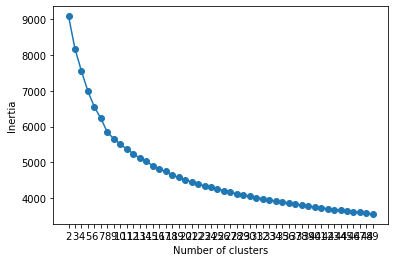

In [8]:
# 8 clusters show good cut of an elbow point [Analysis]
minmax = MinMaxScaler()
X_3step =  pd.DataFrame(minmax.fit_transform(X_2step), columns=X_2step.columns)

inertia = {}
for i in range(2,50):
    kmeans = KMeans(n_clusters=i, random_state=123)
    kmeans.fit_predict(X_3step[cont_vars])
    inertia.update({i:kmeans.inertia_})

inertia_df = pd.Series(inertia)
plt.plot(inertia_df,marker="o")
plt.xticks(inertia_df.index)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

In [9]:
# add 8 clusters
n_clusters = 8

kmeans = KMeans(n_clusters=n_clusters, max_iter=500, n_init=20, random_state=123)
cluster_cols = [f"cluster{i+1}" for i in range(n_clusters)]

minmax = MinMaxScaler(feature_range=(0.1,1,1))
X_3step =  pd.DataFrame(minmax.fit_transform(X_2step), columns=X_2step.columns)

X_kmeans = kmeans.fit_transform(X_3step[cont_vars])
X_kmeans = pd.DataFrame(X_kmeans, columns=cluster_cols, index = X.index)

X_3step = X_3step.join(X_kmeans)
X_3step

,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence,...,key_11.0,key_Missing,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8
0,0.596443,0.647120,0.938124,0.712507,0.105334,0.491584,0.520250,0.745200,0.236412,0.845116,...,0.1,0.1,0.695181,0.546457,0.679398,0.516037,0.307385,0.585809,0.686943,0.878982
1,0.547247,0.157076,0.857145,0.823533,0.104496,0.779623,0.539469,0.829883,0.502740,0.831458,...,0.1,0.1,0.518975,0.434133,0.953212,0.320216,0.582449,0.170143,0.575520,0.888018
2,0.559789,0.228542,0.362704,0.778576,0.101420,0.547513,0.554812,0.629280,0.180529,0.639299,...,0.1,0.1,0.228376,0.544202,0.838803,0.598171,0.673419,0.583477,0.543307,0.828197
3,0.660682,0.518961,0.750225,0.579085,0.104172,0.402576,0.429145,0.504870,0.349801,0.660570,...,0.1,0.1,0.569140,0.442754,0.465877,0.560904,0.303811,0.624888,0.404666,0.741319
4,0.506179,0.522596,0.767657,0.741811,0.105360,0.402799,0.723517,0.620586,0.383496,0.849018,...,0.1,0.1,0.538626,0.394977,0.696305,0.456338,0.348926,0.550104,0.596653,0.833051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0.640169,0.228542,0.867790,0.543263,0.106094,0.552254,0.399161,0.732567,0.207538,0.407891,...,0.1,0.1,0.592734,0.591694,0.757786,0.553015,0.609365,0.594835,0.423288,0.811821
39996,0.555804,0.167606,0.814923,0.870321,0.104687,0.466720,0.432323,0.890105,0.448406,0.877338,...,0.1,0.1,0.472894,0.382367,0.934594,0.175619,0.543401,0.407817,0.557871,0.867020
39997,0.495703,0.843287,0.603371,0.354381,0.105311,0.440773,0.261981,0.456219,0.527088,0.407639,...,0.1,0.1,0.983387,0.937145,0.215899,1.005287,0.645662,1.033437,0.715445,0.915317
39998,0.561126,0.228542,0.562603,0.710244,0.103948,0.729534,0.571384,0.639042,0.301581,0.867308,...,0.1,0.1,0.316033,0.385407,0.835543,0.449093,0.535379,0.299627,0.507995,0.817109


## Step 4: Feature engineering 2- interaction

In [10]:
interact_fe = CombineWithReferenceFeature(
    variables_to_combine = cont_vars,
    reference_variables=cont_vars,
    operations=['sub', 'div','add'])

X_4step = interact_fe.fit_transform(X_3step)
X_4step.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence,...,song_duration_ms_add_audio_valence,acousticness_add_audio_valence,danceability_add_audio_valence,energy_add_audio_valence,instrumentalness_add_audio_valence,liveness_add_audio_valence,loudness_add_audio_valence,speechiness_add_audio_valence,tempo_add_audio_valence,audio_valence_add_audio_valence
0,0.596443,0.647120,0.938124,0.712507,0.105334,0.491584,0.520250,0.745200,0.236412,0.845116,...,1.441559,1.492237,1.783240,1.557624,0.950450,1.336701,1.365367,1.590316,1.081528,1.690233
1,0.547247,0.157076,0.857145,0.823533,0.104496,0.779623,0.539469,0.829883,0.502740,0.831458,...,1.378705,0.988533,1.688603,1.654991,0.935953,1.611081,1.370927,1.661341,1.334198,1.662916
2,0.559789,0.228542,0.362704,0.778576,0.101420,0.547513,0.554812,0.629280,0.180529,0.639299,...,1.199088,0.867840,1.002003,1.417875,0.740719,1.186812,1.194111,1.268578,0.819828,1.278597
3,0.660682,0.518961,0.750225,0.579085,0.104172,0.402576,0.429145,0.504870,0.349801,0.660570,...,1.321253,1.179532,1.410796,1.239655,0.764743,1.063146,1.089715,1.165441,1.010372,1.321141
4,0.506179,0.522596,0.767657,0.741811,0.105360,0.402799,0.723517,0.620586,0.383496,0.849018,...,1.355197,1.371614,1.616675,1.590829,0.954378,1.251817,1.572534,1.469604,1.232514,1.698035


## Step 5: Feature engineering 3- polynomial features


In [11]:
# create 3 degree polynomial features
poly_fe = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
X_5step_temp = poly_fe.fit_transform(X_4step[cont_vars])
poly_fe_name = poly_fe.get_feature_names(X_4step[cont_vars].columns)
X_5step_temp = pd.DataFrame(X_5step_temp, columns =poly_fe_name)
X_5step = pd.concat([X_4step, X_5step_temp], axis=1, join='inner')
X_5step.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence,...,speechiness^3,speechiness^2 tempo,speechiness^2 audio_valence,speechiness tempo^2,speechiness tempo audio_valence,speechiness audio_valence^2,tempo^3,tempo^2 audio_valence,tempo audio_valence^2,audio_valence^3
0,0.596443,0.647120,0.938124,0.712507,0.105334,0.491584,0.520250,0.745200,0.236412,0.845116,...,0.413827,0.131285,0.469313,0.041650,0.148887,0.532238,0.013213,0.047234,0.168850,0.603600
1,0.547247,0.157076,0.857145,0.823533,0.104496,0.779623,0.539469,0.829883,0.502740,0.831458,...,0.571545,0.346240,0.572630,0.209751,0.346897,0.573717,0.127066,0.210149,0.347555,0.574805
2,0.559789,0.228542,0.362704,0.778576,0.101420,0.547513,0.554812,0.629280,0.180529,0.639299,...,0.249190,0.071488,0.253158,0.020509,0.072626,0.257188,0.005884,0.020835,0.073783,0.261283
3,0.660682,0.518961,0.750225,0.579085,0.104172,0.402576,0.429145,0.504870,0.349801,0.660570,...,0.128688,0.089162,0.168375,0.061776,0.116660,0.220302,0.042802,0.080828,0.152637,0.288242
4,0.506179,0.522596,0.767657,0.741811,0.105360,0.402799,0.723517,0.620586,0.383496,0.849018,...,0.239005,0.147695,0.326980,0.091269,0.202060,0.447338,0.056401,0.124865,0.276436,0.611998


## Feature scaling before modeling

In [12]:
std_scaler = StandardScaler()
X_5step_scaled =  pd.DataFrame(std_scaler.fit_transform(X_5step), columns=X_5step.columns)
X_5step_scaled.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence,...,speechiness^3,speechiness^2 tempo,speechiness^2 audio_valence,speechiness tempo^2,speechiness tempo audio_valence,speechiness audio_valence^2,tempo^3,tempo^2 audio_valence,tempo audio_valence^2,audio_valence^3
0,0.516346,1.328643,1.376518,0.104510,-0.217778,-0.300535,0.307741,0.453796,-1.405563,0.669562,...,0.229905,-0.629958,0.579372,-1.040798,-0.642042,0.774967,-0.945805,-1.064984,-0.598481,0.599056
1,-0.081323,-0.728254,0.843398,0.740795,-0.224824,1.826783,0.463230,0.962532,0.388418,0.590145,...,0.865437,1.083681,1.095451,0.629529,1.214850,0.988533,0.078606,0.499746,0.754491,0.486471
2,0.071046,-0.428285,-2.411751,0.483149,-0.250676,0.112529,0.587358,-0.242602,-1.781984,-0.527168,...,-0.433504,-1.106660,-0.500340,-1.250862,-1.357201,-0.641217,-1.011753,-1.318532,-1.318234,-0.739356
3,1.296771,0.790712,0.139491,-0.660129,-0.227540,-0.957912,-0.429334,-0.989996,-0.641775,-0.403482,...,-0.919069,-0.965763,-0.923834,-0.840809,-0.944268,-0.831138,-0.679575,-0.742328,-0.721232,-0.633950
4,-0.580244,0.805969,0.254252,0.272450,-0.217555,-0.956260,1.952238,-0.294828,-0.414805,0.692246,...,-0.474546,-0.499136,-0.131592,-0.547755,-0.143403,0.337830,-0.557220,-0.319375,0.216048,0.631890


## Feature selection before modelling

In [13]:
# remove duplicates columns
uniq, idxs = np.unique(X_5step_scaled, return_index=True, axis=1)
X_5step_dropduplicates = pd.DataFrame(uniq, index=X_5step_scaled.index, columns=X_5step_scaled.columns[idxs])
X_5step_dropduplicates

,tempo_sub_acousticness,tempo_sub_danceability,cluster5,tempo_sub_song_duration_ms,tempo,tempo_sub_audio_valence,instrumentalness_sub_acousticness,tempo_div_acousticness,tempo_div_danceability,tempo_add_liveness,...,acousticness danceability speechiness,danceability_div_tempo,acousticness loudness audio_valence,acousticness danceability audio_valence,acousticness danceability^2,acousticness danceability energy,key_10.0,acousticness_div_tempo,liveness_na,acousticness danceability loudness
0,-2.073020,-2.009789,-1.698478,-1.427683,-1.405563,-1.372231,-1.319300,-1.313529,-1.310715,-1.280206,...,2.550305,2.630035,2.637282,2.769245,2.840433,2.840677,2.880625,2.963994,2.964713,3.002341
1,0.912423,-0.338907,0.197464,0.365819,0.388418,-0.185744,0.565389,1.016668,-0.197330,1.565923,...,-0.391785,-0.183657,-0.510431,-0.471037,-0.464554,-0.419959,-0.347147,-0.761834,-0.337301,-0.491409
2,-0.641438,0.489686,0.824496,-1.536980,-1.781984,-0.736857,0.278216,-0.964578,-0.492871,-1.279967,...,-0.906252,0.194493,-0.354476,-0.947265,-1.085633,-0.889679,-0.347147,0.703274,-0.337301,-0.874144
3,-1.119615,-0.560303,-1.723114,-1.148303,-0.641775,-0.109685,-0.830035,-1.059813,-0.597611,-1.155034,...,0.340860,0.363076,0.616809,0.702264,0.821365,0.741510,-0.347147,1.037681,-0.337301,0.865432
4,-1.000965,-0.482060,-1.412148,-0.078549,-0.414805,-0.765470,-0.839463,-1.010675,-0.486760,-0.980894,...,0.793391,0.185312,3.173977,1.376151,0.936890,1.472722,2.880625,0.851952,-0.337301,2.634917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,-0.534834,-1.810329,0.382985,-1.840349,-1.600055,0.358220,0.296220,-0.867453,-1.353476,-1.116966,...,-0.101995,2.895061,-0.999292,-0.721863,-0.051879,-0.451731,-0.347147,0.450131,-0.337301,-0.397575
39996,0.656401,-0.397178,-0.071686,0.008335,0.022426,-0.610415,0.525557,0.584977,-0.318097,-0.319474,...,-0.306776,-0.043881,-0.611653,-0.407321,-0.494366,-0.338908,-0.347147,-0.667579,-0.337301,-0.686539
39997,-1.699982,0.999132,0.633172,0.797205,0.552426,1.713432,-2.075125,-1.100084,0.758031,-0.048735,...,0.648020,-0.880136,-0.222193,0.300183,0.929898,0.283887,2.880625,1.216391,-0.337301,0.380123
39998,-0.163643,0.110355,-0.126981,-0.856501,-0.966587,-1.190107,0.287955,-0.529269,-0.365351,0.276009,...,-0.647127,0.015963,0.118947,-0.474494,-0.777976,-0.618189,-0.347147,-0.077501,-0.337301,-0.479411


In [14]:
feature_sel_pipe1 = Pipeline([
    ('constant', DropConstantFeatures(tol=0.998)),
    ('duplicates', DropDuplicateFeatures()),
    ('correlated', DropCorrelatedFeatures())
])

X_5step_feature_sel_v1 = feature_sel_pipe1.fit_transform(X_5step_dropduplicates)

## Modelling stacking

In [16]:
xgb_params = {'n_estimators': 881,
 'max_depth': 3,
 'min_child_weight': 3,
 'learning_rate': 0.01,
 'scale_pos_weight': 1,
 'subsample': 0.8,
 'colsample_bytree': 0.8
 }

xgb_m_stack = XGBClassifier(**xgb_params, random_state=123 , eval_metric='aucpr')
xgb_m_stack.fit(X_5step_feature_sel_v1.to_numpy(), y)
xgb_out = xgb_m_stack.predict_proba(X_5step_feature_sel_v1.to_numpy())[:,1]

In [19]:
lgbm_params = {'lambda_l1': 1.9507389836797324,
 'lambda_l2': 1.5984538949536956e-07,
 'num_leaves': 7,
 'feature_fraction': 0.6549181528694273,
 'bagging_fraction': 0.9394477119816492,
 'bagging_freq': 2,
 'min_child_samples': 84}

lgbm_m_stack = LGBMClassifier(**lgbm_params, random_state=123 )
lgbm_m_stack.fit(X_5step_feature_sel_v1.to_numpy(), y)
lgbm_out = lgbm_m_stack.predict_proba(X_5step_feature_sel_v1.to_numpy())[:,1]

[LightGBM] [Warning] feature_fraction is set=0.6549181528694273, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6549181528694273
[LightGBM] [Warning] lambda_l1 is set=1.9507389836797324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9507389836797324
[LightGBM] [Warning] bagging_fraction is set=0.9394477119816492, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9394477119816492
[LightGBM] [Warning] lambda_l2 is set=1.5984538949536956e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5984538949536956e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


In [20]:
rf_params = {
    'n_estimators': 769, 
    'max_depth': 12, 
    'min_samples_split': 130, 
    'min_samples_leaf': 32, 
    'max_features': 'auto', 
    'bootstrap': True
}

rf_m_stack = RandomForestClassifier(**rf_params, random_state=123 )
rf_m_stack.fit(X_5step_feature_sel_v1.to_numpy(), y)
rf_out = rf_m_stack.predict_proba(X_5step_feature_sel_v1.to_numpy())[:,1]

In [21]:
# Add predicted probabilities to existing features
X_5step_blend = X_5step_feature_sel_v1.copy()
X_5step_blend['xgb'] = xgb_out
X_5step_blend['lgbm'] = lgbm_out
X_5step_blend['rf'] = rf_out

In [26]:
x_train, x_valid, y_train, y_valid = train_test_split(X_5step_blend,y, test_size = 0.25, random_state = 123, stratify=y)
rf_blend = RandomForestClassifier(**rf_params, random_state=123)
rf_blend.fit(x_train, y_train)

preds_train = rf_blend.predict_proba(x_train)[:,1]
preds_valid = rf_blend.predict_proba(x_valid)[:,1]
auc_train = roc_auc_score(y_train, preds_train)
auc_valid = roc_auc_score(y_valid, preds_valid)

print(f"train: {auc_train:.5f} | valid: {auc_valid:.5f} |")

rf_blend_full = RandomForestClassifier(**rf_params, random_state=123)
rf_blend_full.fit(X_5step_blend, y)


train: 0.89095 | valid: 0.83914 |


RandomForestClassifier(max_depth=12, min_samples_leaf=32, min_samples_split=130,
                       n_estimators=769, random_state=123)

## Testing data submission

In [38]:
# imputation and feature transformation
X_2step_test = twostep_pipe.fit_transform(test)

# add clusters
n_clusters = 8

X_3step_test =  pd.DataFrame(minmax.transform(X_2step_test), columns=X_2step_test.columns)

X_kmeans_test = kmeans.transform(X_3step_test[cont_vars])
X_kmeans_test = pd.DataFrame(X_kmeans_test, columns=cluster_cols, index = test.index)

X_3step_test = X_3step_test.join(X_kmeans_test)
X_3step_test

# feature interaction
X_4step_test = interact_fe.transform(X_3step_test)

# create 3 degree polynomial features
X_5step_temp_test = poly_fe.transform(X_4step_test[cont_vars])
poly_fe_name_test = poly_fe.get_feature_names(X_4step_test[cont_vars].columns)
X_5step_temp_test = pd.DataFrame(X_5step_temp_test, columns =poly_fe_name_test)
X_5step_test = pd.concat([X_4step_test, X_5step_temp_test], axis=1, join='inner')
X_5step_test.head()

# Scaling
X_5step_scaled_test =  pd.DataFrame(std_scaler.transform(X_5step_test), columns=X_5step_test.columns)

# remove duplicates columns
X_5step_scaled_dropdup_test = X_5step_scaled_test.T.drop_duplicates().T
X_5step_dropduplicates_test = X_5step_scaled_dropdup_test[X_5step_dropduplicates.columns.tolist()]
X_5step_dropduplicates_test

# drop correlated features
X_5step_feature_sel_v1_test = feature_sel_pipe1.transform(X_5step_dropduplicates_test)

# model stacking
xgb_out_test = xgb_m_stack.predict_proba(X_5step_feature_sel_v1_test.to_numpy())[:,1]
lgbm_out_test = lgbm_m_stack.predict_proba(X_5step_feature_sel_v1_test.to_numpy())[:,1]
rf_out_test = rf_m_stack.predict_proba(X_5step_feature_sel_v1_test.to_numpy())[:,1]

# Add predicted probabilities to existing features
X_5step_blend_test = X_5step_feature_sel_v1_test.copy()
X_5step_blend_test['xgb'] = xgb_out_test
X_5step_blend_test['lgbm'] = lgbm_out_test
X_5step_blend_test['rf'] = rf_out_test

In [46]:
pred_test = rf_blend_full.predict_proba(X_5step_blend_test)[:,1]
pred_test = rf_blend_full.predict(X_5step_blend_test)

In [48]:
submission = test.copy()
submission['song_popularity'] = pred_test
submission.reset_index(inplace=True)
submission = submission[['id', 'song_popularity']]
# submission
submission.to_csv('submission.csv', index=False)